**Loading Libraries**

In [1]:
library(diversedata)
library(tidyverse)  # includes ggplot2, readr, dplyr
library(janitor)    # for data cleaning
library(knitr)  # For kable() function
library(car)    # For leveneTest()
library(ggthemes)   # extra ggplot themes
library(ggalt)  # For geom_dumbbell
library(FSA) # For Dunn's test

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.abs

# 1 Data Cleaning & Processing

In [2]:
gender_data <- genderassessment |> 
  clean_names() |> 
  drop_na(score) |> 
  mutate(
    industry = as.factor(industry),
    ownership_type = as.factor(ownership)
  )
kable(head(gender_data))



|company              |country        |region                |industry                        |ownership | year| score| percent_score| strategic_action| gender_targets| gender_due_diligence| grievance_mechanisms| stakeholder_engagement| corrective_action| gender_leadership| development_recruitment| employee_data_by_sex| supply_chain_gender_leadership| enabling_environment_union_rights| gender_procurement| gender_pay_gap| carer_leave_paid| childcare_support| flex_work| living_wage_supply_chain| health_safety| health_safety_supply_chain| violence_prevention| violence_remediation|ownership_type |
|:--------------------|:--------------|:---------------------|:-------------------------------|:---------|----:|-----:|-------------:|----------------:|--------------:|--------------------:|--------------------:|----------------------:|-----------------:|-----------------:|-----------------------:|--------------------:|------------------------------:|---------------------------------:|---------

# 2 Exploratory Data Analysis

**Average Overall Assessment Score by Industry**

In [3]:
industry_stats <- gender_data |> 
  group_by(industry) |> 
  summarise(
    avg_score = mean(score, na.rm = TRUE),
    median_score = median(score, na.rm = TRUE),
    sd_score = sd(score, na.rm = TRUE),
    n = n()
  ) |> 
  arrange(desc(avg_score))

kable(industry_stats, digits = 2, caption = "Average Score by Industry")



Table: Average Score by Industry

|industry                          | avg_score| median_score| sd_score|   n|
|:---------------------------------|---------:|------------:|--------:|---:|
|Personal & Household Products     |     14.69|        15.60|     4.64|  20|
|Electronics                       |     12.63|        13.30|     5.44|  55|
|Pharmaceuticals & Biotechnology   |     12.37|        12.90|     5.80|  29|
|Apparel & Footwear                |     11.49|        10.80|     5.98|  68|
|Banks                             |     10.73|        11.20|     5.80| 150|
|IT Software & Services            |     10.24|        10.25|     5.85|  34|
|Retail                            |      9.71|        10.45|     6.40|  18|
|Insurance                         |      9.60|        10.20|     5.26|  71|
|Motor Vehicles & Parts            |      9.54|        10.70|     6.23|  45|
|Oil & Gas                         |      9.50|        10.30|     5.93|  97|
|Capital Goods                     |    

**Visualization: Average Overall Gender Assessment by Industry Group**

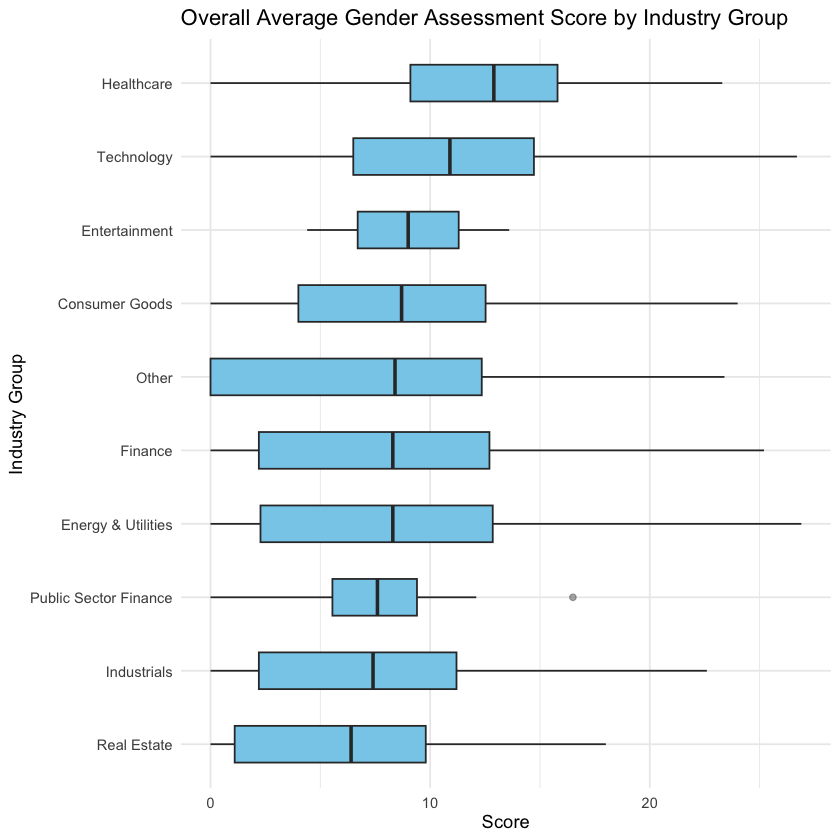

In [4]:
gender_data_grouped <- gender_data |> 
  mutate(industry_group = case_when(
    industry %in% c("Apparel & Footwear", "Food Production", "Food Retailers", 
                    "Retail", "Personal & Household Products", "Agricultural Products") ~ "Consumer Goods",
    
    industry %in% c("Banks", "Insurance", "Pension Funds", "Sovereign Wealth Funds", 
                    "Alternative Asset Managers", "Traditional Asset Managers", 
                    "Investment Consultants", "Payments") ~ "Finance",
    
    industry %in% c("Pharmaceuticals & Biotechnology") ~ "Healthcare",
    
    industry %in% c("IT Software & Services", "Telecommunications", "Electronics") ~ "Technology",
    
    industry %in% c("Oil & Gas", "Utilities") ~ "Energy & Utilities",
    
    industry %in% c("Chemicals", "Capital Goods", "Freight & logistics", 
                    "Passenger Transport", "Metals & Mining", "Containers & Packaging", 
                    "Motor Vehicles & Parts", "Postal & Courier Activities", 
                    "Waste Management", "Paper & Forest Products") ~ "Industrials",
    
    industry %in% c("Construction & Engineering", "Construction Materials & Supplies", "Real Estate") ~ "Real Estate",
    
    industry %in% c("Development Finance Institutions") ~ "Public Sector Finance",
    
    industry %in% c("Entertainment") ~ "Entertainment",
    
    TRUE ~ "Other"
  ))

gender_by_group <- ggplot(gender_data_grouped, aes(x = reorder(industry_group, score, FUN = median), y = score)) +
  geom_boxplot(width = 0.5, fill = "skyblue", outlier.alpha = 0.4) +  # width < 1 reduces box width
  coord_flip() +
  labs(
    title = "Overall Average Gender Assessment Score by Industry Group",
    x = "Industry Group", y = "Score"
  ) +
  theme_minimal()

gender_by_group

**Comparison of Average Overall Gender Assessment Scores Between 2023 vs 2024 by Region**

`summarise()` has grouped output by 'region'. You can override using the
`.groups` argument.
Warning message:
“Using the `size` aesthetic with geom_segment was deprecated in ggplot2 3.4.0.
ℹ Please use the `linewidth` aesthetic instead.”


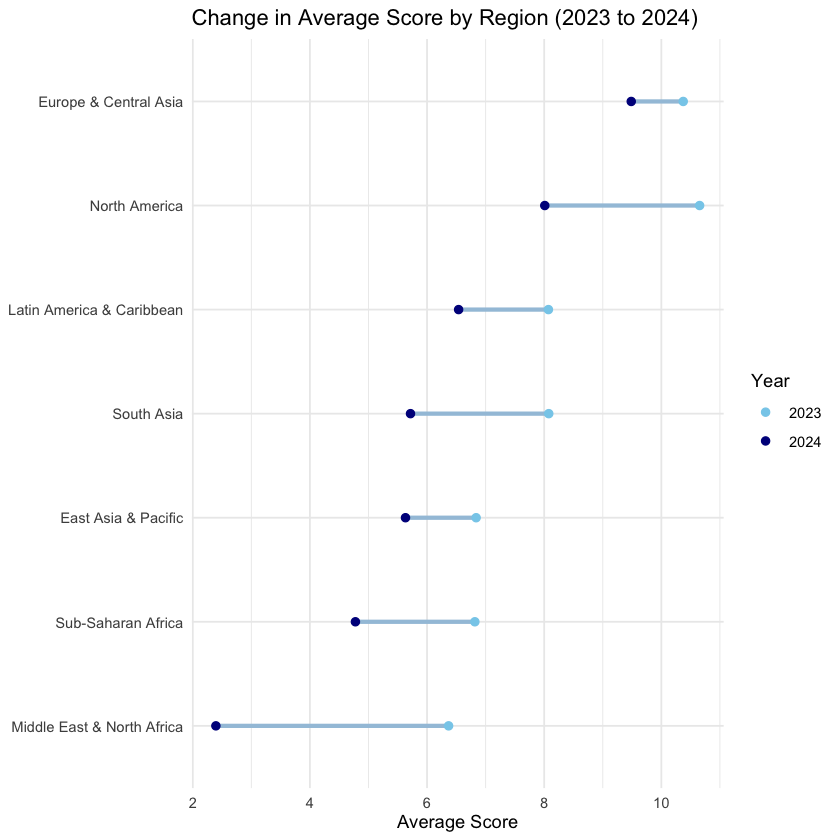

In [5]:
region_wide <- gender_data |> 
  filter(year %in% c(2023, 2024)) |>  # Ensure only these years are included
  group_by(region, year) |> 
  summarise(avg_score = mean(score, na.rm = TRUE)) |> 
  pivot_wider(
    names_from = year, 
    values_from = avg_score,
    names_prefix = ""  # Removes automatic "year" prefix
  ) |> 
  ungroup()

ggplot(region_wide, aes(x = `2023`, xend = `2024`, y = reorder(region, `2024`))) +
  geom_dumbbell(
    size = 1.2,  # thinner connecting line
    colour = "#a3c4dc",       # light blue line
    colour_x = "#87CEEB",     # skyblue for 2023
    colour_xend = "#00008B"   # dark blue for 2024
  ) +
  # Dummy points to create legend
  geom_point(aes(x = `2023`, color = "2023"), size = 2) +
  geom_point(aes(x = `2024`, color = "2024"), size = 2) +
  scale_color_manual(
    name = "Year",
    values = c("2023" = "#87CEEB", "2024" = "#00008B")
  ) +
  labs(
    title = "Change in Average Score by Region (2023 to 2024)",
    x = "Average Score", y = "Region"
  ) +
  theme_minimal() +
  theme(axis.title.y = element_blank())

# 3 Gender Assessment Score by Ownership Type

In addition to industry-based analysis, we examine whether ownership structure affects the overall gender performance scores. The following box plot illustrates how scores vary by ownership category

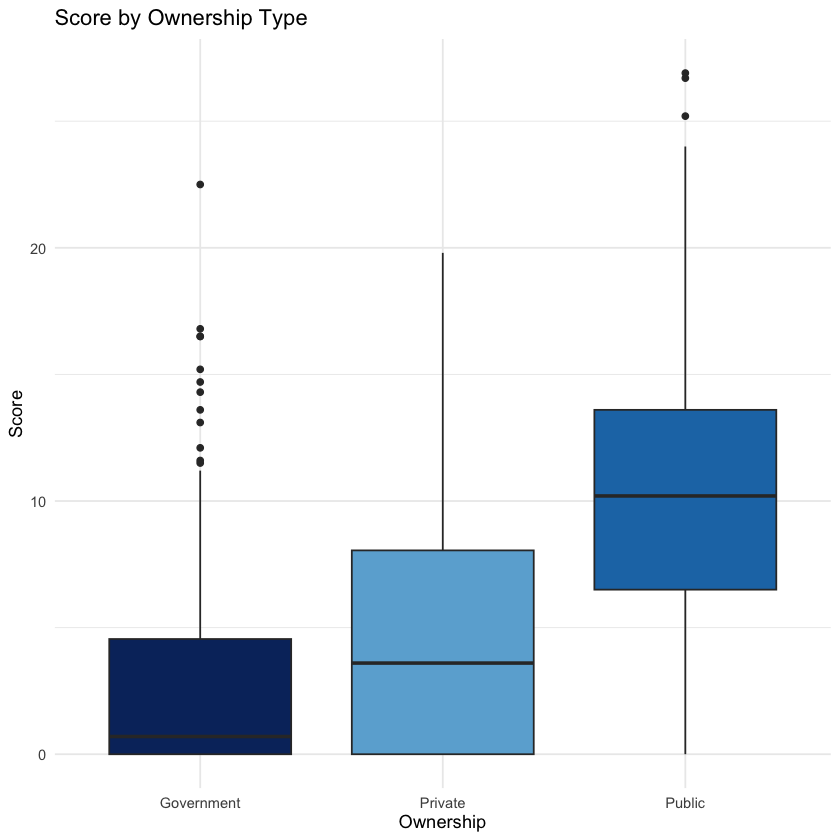

In [6]:
filtered_data <- gender_data |>
  subset(!is.na(score) & !is.na(ownership))

ggplot(filtered_data, aes(x = ownership, y = score, fill = ownership)) +
  geom_boxplot() +
  scale_fill_manual(values = c(
    "Public" = "#1f77b4",     # blue
    "Private" = "#6baed6",    # lighter blue
    "Government" = "#08306b"  # dark blue
  )) +
  labs(title = "Score by Ownership Type", x = "Ownership", y = "Score") +
  theme_minimal() +
  theme(legend.position = "none")

**Hypothesis Testing: Gender Assessment Scores by Ownership Type**
We aim to test whether companies with different ownership types have significantly different mean gender assessment scores.

Hypotheses

-   Null Hypothesis (H₀):
    The mean score is the same across all ownership groups.
    $$
    \mu_{\text{public}} = \mu_{\text{Private}} = \mu_{\text{Government}}
    $$

-   Alternative Hypothesis (Hₐ):
    Not all group means are equal.


**Assumption checks for ANOVA**

Before applying ANOVA to compare gender assessment scores across ownership types, it is essential to verify that the assumptions underlying the test are met.

### 1. Independence of Observations

-   Observations within and across groups must be independent: This assumption is satisfied by the data set design, provided that each company appears only once. This assumption is generally satisfied by the data set design, provided that each company appears only once and that there is no clustering of related firms or repeated measurements. Since our data set includes one record per company without repeated measures, we consider the independence assumption to be reasonably met.

### 2. Normality of Residuals

ANOVA assumes that the residuals are normally distributed. We assess this using the Shapiro-Wilk test:

In [7]:
anova_model <- aov(score ~ ownership, data = gender_data)
shapiro.test(residuals(anova_model))


	Shapiro-Wilk normality test

data:  residuals(anova_model)
W = 0.98844, p-value = 1.423e-11


**Inference**

Since the p-value is less than 0.05, we reject the null hypothesis of normality. The residuals are not normally distributed, violating the normality assumption for ANOVA.

### 3. Homogeneity of Variances

Another key assumption is that the variance of scores is roughly equal across the ownership types. We use **Levene’s Test** to assess this:

In [8]:
leveneTest(score ~ ownership, data = gender_data)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,25.55796,1.097163e-11
,1993,NA,NA


**Inference**

As the p-value is well below 0.05, we reject the null hypothesis of equal variances. The assumption of **homogeneity of variance is violated**.

Since both the normality of residuals and homogeneity of variance assumptions are violated, a non-parametric alternative to ANOVA is more appropriate.

# 4 Kruskal-Wallis test

To evaluate whether the score differs across different types of business ownership, we use the Kruskal–Wallis test.

**Hypotheses**

-   Null Hypothesis (H₀):\
    The median score is the same across all ownership groups.\
    $$
    \tilde{\mu}_{\text{public}} = \tilde{\mu}_{\text{Private}} = \tilde{\mu}_{\text{Government}}
    $$

-   Alternative Hypothesis (Hₐ):\
    Not all group medians are equal.\

**Assumptions of the Kruskal-Wallis Test**

-   Ordinal or Continuous Dependent Variable: The variable `score` is numeric, satisfying this assumption.

-   Independent Groups: Each `business` (or observation) belongs to only one ownership type. This ensures group independence.

-   Independent Observations: Each row in the data set represents a unique business entity, so the observations are independent.

In [9]:
kruskal.test(score ~ ownership, data = gender_data)


	Kruskal-Wallis rank sum test

data:  score by ownership
Kruskal-Wallis chi-squared = 517.7, df = 2, p-value < 2.2e-16


-   The p-value is small (\< 0.05), meaning we **reject the null hypothesis (H₀)** that all ownership groups have the same median score.
-   There are statistically significant differences in median `score` between at least two ownership types.

Since the test indicates that not all ownership groups are equal, we need to conduct a post-hoc test to identify which specific groups differ.

# 5  Dunn’s Post-Hoc Test (with Bonferroni Correction)

To determine which ownership groups differ, we conduct Dunn's test with Bonferroni adjustment for multiple comparisons.

In [10]:
dunnTest(score ~ ownership, data = gender_data, method = "bonferroni")

Warning message:
“ownership was coerced to a factor.”
Warning message:
“Some rows deleted from 'x' and 'g' because missing data.”
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Bonferroni method.




            Comparison          Z      P.unadj        P.adj
1 Government - Private  -4.232728 2.308732e-05 6.926197e-05
2  Government - Public -18.867414 2.113945e-79 6.341836e-79
3     Private - Public -16.052311 5.507422e-58 1.652227e-57

**Inference**

Pairwise comparisons using Dunn’s test (with Bonferroni correction) indicate statistically significant differences in gender assessment scores across all ownership types:

-   Government-owned companies have significantly lower scores than both Private and Public companies.

-   Private companies also score significantly lower than Public companies.


# Discussion

This analysis highlights notable disparities in gender assessment performance across industries, ownership types, and regions. Industries demonstrated varying levels of engagement with gender equity, with the Personal & Household Products sector achieving the highest average scores. In contrast, the Pension Funds industry consistently lagged behind, pointing to potential structural or cultural barriers that may impede progress in specific sectors.

Ownership structure played a critical role in performance. Government-owned companies significantly outperformed both privately held and publicly traded firms. In contrast, publicly traded companies, despite their visibility and access to resources, showed relatively poor performance.

Despite the insights provided, this analysis faces some limitations. While average scores are useful for summarizing overall trends, they can hide meaningful differences within subgroup like firm size or revenue.